In [12]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')

In [3]:
X, y = mnist.data, mnist.target

In [10]:
some_digit = X.loc[0,:] #X[0] - será usado mais a frente na predição
# converter de serie pandas para numpy (na verdade já vê a serie como um array)
some_digit_np = some_digit.to_numpy() #precisa transformar em numpy, pois Series não tem método reshape
some_digit_image = some_digit_np.reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

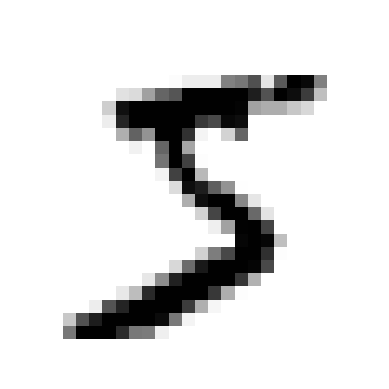

In [11]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')

In [13]:
# como o label é uma string, vamos converter para número, pois os algoritmos ML trabalham com números
y = y.astype(np.uint8) # unsigned int de 1 byte, o famoso unsigned char do C

In [14]:
# o dataset MNIST já é separado em conjunto de treino e teste, onde o conjunto de treino está embaralhado (shuffle),
# o que é bom neste caso

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [20]:
# vamos exemplificar treinando um classificador binário para reconhecer apenas o número 5, portanto, classes 5 e não 5
y_train_5 = (y_train == 5) # 1(true) para o 5, 0(false) para os demais - mascara
y_test_5 = (y_test == 5)

#cria mascara
print(y_train_5.value_counts())
print(y_test_5.value_counts())

class
False    54579
True      5421
Name: count, dtype: int64
class
False    9108
True      892
Name: count, dtype: int64


Aqui vemos o desbalanceamento próprio ao binarizar o problema. Antes fazendo o cross_val_score na base desbalanceada com SGD

In [21]:
from sklearn.linear_model import SGDClassifier
model_sgd = SGDClassifier(random_state=42) #se quiser reproduzir os resultados
model_sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_sgd, X_train, y_train_5, cv=10, scoring='accuracy', n_jobs=-1)
print(f'{np.mean(scores)*100:.2f}')

0.9635333333333334


Vamos agora introduzir a possibilidade de balancear a classe minoritária com SMOTE

In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [46]:
def my_cross_validation(model, X, y, oversampling=False):
    kfold = KFold(n_splits=10) #cv=10
    accs_split = []
    for idx, (idx_train, idx_validation) in enumerate(kfold.split(X)):
        X_split_train = X.iloc[idx_train,:]
        #y_split_train = y.iloc[idx_train,:]
        y_split_train = y.iloc[idx_train]
        # se oversampling, aplicar só no split de treino, pois o de validação precisa manter a característica de balance original
        if oversampling:
            sm = SMOTE(random_state=42)
            X_split_train, y_split_train = sm.fit_resample(X_split_train, y_split_train)
        
        model.fit(X_split_train, y_split_train.values.flatten())
        
        X_split_validation = X.iloc[idx_validation, :]
        #y_split_validation = y.iloc[idx_validation, :]
        y_split_validation = y.iloc[idx_validation]
        
        y_pred_validation = model.predict(X_split_validation)
        acc_split = accuracy_score(y_split_validation, y_pred_validation)
        accs_split.append(acc_split)
        
        print(f'accuracy at split {idx}: {acc_split}')
    return accs_split

In [47]:
avg_acc_without_smote = np.mean(my_cross_validation(model_sgd, X_train, y_train_5, oversampling=False))*100
avg_acc_with_smote = np.mean(my_cross_validation(model_sgd, X_train, y_train_5, oversampling=True))*100
print(f'avg_acc_without_smote {avg_acc_without_smote:.02f}, avg_acc_with_smote: {avg_acc_with_smote:.02f}')

accuracy at split 0: 0.97
accuracy at split 1: 0.9553333333333334
accuracy at split 2: 0.9518333333333333
accuracy at split 3: 0.9681666666666666
accuracy at split 4: 0.8958333333333334
accuracy at split 5: 0.9678333333333333
accuracy at split 6: 0.9506666666666667
accuracy at split 7: 0.962
accuracy at split 8: 0.9486666666666667
accuracy at split 9: 0.9601666666666666
accuracy at split 0: 0.9615
accuracy at split 1: 0.8823333333333333
accuracy at split 2: 0.8721666666666666
accuracy at split 3: 0.96
accuracy at split 4: 0.959
accuracy at split 5: 0.9205
accuracy at split 6: 0.9415
accuracy at split 7: 0.946
accuracy at split 8: 0.9601666666666666
accuracy at split 9: 0.9646666666666667
avg_acc_without_smote 95.30, avg_acc_with_smote: 93.68


Se fizer o cv com toda a base balanceada, o validation estará balanceado, favorecendo erroneamente a métrica


In [48]:
from sklearn.model_selection import cross_val_score
sm = SMOTE(random_state=42)
X_train, y_train_5 = sm.fit_resample(X_train, y_train_5)
print(np.mean(cross_val_score(model_sgd, X_train, y_train_5.values.flatten(), scoring='accuracy', cv=10))*100) #ESTA MÉDIA DE ACURÁCIA NÃO É REAL, FOI ENVIESADA PELO DEV

93.52499224914463
